In [77]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [78]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [79]:
%matplotlib inline
from matplotlib import pylab as plt
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (15.0, 8.0)
import pandas as pd
import seaborn as sns

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

#from keras.utils.vis_utils import model_to_dot

In [80]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [81]:
#from bokeh.charts import TimeSeries, output_file, show
#from bokeh.io import output_notebook
#output_notebook()

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd
import numpy as np

# Render Bokeh plots inside Jupyter notebook
output_notebook()

Loading BokehJS ...

### Data Preparation
Eleven months data from one bed one bath apartment unit in San Jose, CA region was picked for this experiment. The electricity consumption is recorded in 15 minutes interval by the energy supply company. The raw data contains information such as type, date, start time, end time, usage, units, cost and notes fields. The start time and end time is the measurement interval. In this data, the interval is 15 minutes. The usage in 15 minutes interval is provided in kWh unit, and the cost for the consumption is presented in the dollar. Before we deep dive into the data, some quick feature engineering steps are done to enrich the data with more features. 

In [82]:
data = pd.read_csv("C:/Users/kumar/Downloads/LSTM_Electricity_01-master/D202.csv")
data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN


#### Creating Date and Time Filed

In [83]:
data["DATE_TIME"] = pd.to_datetime(data.DATE + " " + data["END TIME"])

C:\Users\kumar\AppData\Local\Temp\ipykernel_10024\2928561893.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["DATE_TIME"] = pd.to_datetime(data.DATE + " " + data["END TIME"])


In [84]:
data

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN,2016-11-01 00:14:00
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN,2016-11-01 00:29:00
2,Electric usage,11/1/16,0:30,0:44,0.06,kWh,$0.01,NaN,2016-11-01 00:44:00
3,Electric usage,11/1/16,0:45,0:59,0.05,kWh,$0.01,NaN,2016-11-01 00:59:00
4,Electric usage,11/1/16,1:00,1:14,0.03,kWh,$0.01,NaN,2016-11-01 01:14:00
...,...,...,...,...,...,...,...,...,...
31859,Electric usage,9/30/17,22:45,22:59,0.10,kWh,$0.02,NaN,2017-09-30 22:59:00
31860,Electric usage,9/30/17,23:00,23:14,0.11,kWh,$0.02,NaN,2017-09-30 23:14:00
31861,Electric usage,9/30/17,23:15,23:29,0.10,kWh,$0.02,NaN,2017-09-30 23:29:00
31862,Electric usage,9/30/17,23:30,23:44,0.08,kWh,$0.02,NaN,2017-09-30 23:44:00


In [85]:
data["DAY_OF_WEEK"] = data["DATE_TIME"].dt.day_name()
data

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_OF_WEEK
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN,2016-11-01 00:14:00,Tuesday
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN,2016-11-01 00:29:00,Tuesday
2,Electric usage,11/1/16,0:30,0:44,0.06,kWh,$0.01,NaN,2016-11-01 00:44:00,Tuesday
3,Electric usage,11/1/16,0:45,0:59,0.05,kWh,$0.01,NaN,2016-11-01 00:59:00,Tuesday
4,Electric usage,11/1/16,1:00,1:14,0.03,kWh,$0.01,NaN,2016-11-01 01:14:00,Tuesday
...,...,...,...,...,...,...,...,...,...,...
31859,Electric usage,9/30/17,22:45,22:59,0.10,kWh,$0.02,NaN,2017-09-30 22:59:00,Saturday
31860,Electric usage,9/30/17,23:00,23:14,0.11,kWh,$0.02,NaN,2017-09-30 23:14:00,Saturday
31861,Electric usage,9/30/17,23:15,23:29,0.10,kWh,$0.02,NaN,2017-09-30 23:29:00,Saturday
31862,Electric usage,9/30/17,23:30,23:44,0.08,kWh,$0.02,NaN,2017-09-30 23:44:00,Saturday


In [86]:
data["DAY_OF_WEEK_NUM"] = data["DATE_TIME"].dt.dayofweek
data

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_OF_WEEK,DAY_OF_WEEK_NUM
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN,2016-11-01 00:14:00,Tuesday,1
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN,2016-11-01 00:29:00,Tuesday,1
2,Electric usage,11/1/16,0:30,0:44,0.06,kWh,$0.01,NaN,2016-11-01 00:44:00,Tuesday,1
3,Electric usage,11/1/16,0:45,0:59,0.05,kWh,$0.01,NaN,2016-11-01 00:59:00,Tuesday,1
4,Electric usage,11/1/16,1:00,1:14,0.03,kWh,$0.01,NaN,2016-11-01 01:14:00,Tuesday,1
...,...,...,...,...,...,...,...,...,...,...,...
31859,Electric usage,9/30/17,22:45,22:59,0.10,kWh,$0.02,NaN,2017-09-30 22:59:00,Saturday,5
31860,Electric usage,9/30/17,23:00,23:14,0.11,kWh,$0.02,NaN,2017-09-30 23:14:00,Saturday,5
31861,Electric usage,9/30/17,23:15,23:29,0.10,kWh,$0.02,NaN,2017-09-30 23:29:00,Saturday,5
31862,Electric usage,9/30/17,23:30,23:44,0.08,kWh,$0.02,NaN,2017-09-30 23:44:00,Saturday,5


#### Working Day or Not

In [87]:
data["DAY_TYPE"] = data.DATE_TIME.apply(lambda x: 1 if x.dayofweek > 5 else 0  )

In [88]:
data

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_OF_WEEK,DAY_OF_WEEK_NUM,DAY_TYPE
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN,2016-11-01 00:14:00,Tuesday,1,0
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN,2016-11-01 00:29:00,Tuesday,1,0
2,Electric usage,11/1/16,0:30,0:44,0.06,kWh,$0.01,NaN,2016-11-01 00:44:00,Tuesday,1,0
3,Electric usage,11/1/16,0:45,0:59,0.05,kWh,$0.01,NaN,2016-11-01 00:59:00,Tuesday,1,0
4,Electric usage,11/1/16,1:00,1:14,0.03,kWh,$0.01,NaN,2016-11-01 01:14:00,Tuesday,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31859,Electric usage,9/30/17,22:45,22:59,0.10,kWh,$0.02,NaN,2017-09-30 22:59:00,Saturday,5,0
31860,Electric usage,9/30/17,23:00,23:14,0.11,kWh,$0.02,NaN,2017-09-30 23:14:00,Saturday,5,0
31861,Electric usage,9/30/17,23:15,23:29,0.10,kWh,$0.02,NaN,2017-09-30 23:29:00,Saturday,5,0
31862,Electric usage,9/30/17,23:30,23:44,0.08,kWh,$0.02,NaN,2017-09-30 23:44:00,Saturday,5,0


In [89]:
data["DAY_TYPE"].min()

0

In [90]:
data["DAY_TYPE"].max()

1

#### Finding Fedaral Holidays

In [91]:
cal = calendar()
holidays = cal.holidays(start = data.DATE_TIME.min(), end = data.DATE_TIME.max())
data["IS_HOLIDAY"] = data.DATE_TIME.isin(holidays)

In [92]:
data.head(3)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_OF_WEEK,DAY_OF_WEEK_NUM,DAY_TYPE,IS_HOLIDAY
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,NaN,2016-11-01 00:14:00,Tuesday,1,0,False
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,NaN,2016-11-01 00:29:00,Tuesday,1,0,False
2,Electric usage,11/1/16,0:30,0:44,0.06,kWh,$0.01,NaN,2016-11-01 00:44:00,Tuesday,1,0,False


In [93]:
print(data["IS_HOLIDAY"].value_counts())


IS_HOLIDAY
False    31864
Name: count, dtype: int64


In [94]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Create calendar instance
cal = calendar()

# Get list of US federal holidays between min and max dates
holidays = cal.holidays(start=data["DATE_TIME"].min(), end=data["DATE_TIME"].max())

# Check if DATE_TIME falls on a holiday (compare dates only)
data["IS_HOLIDAY"] = data["DATE_TIME"].dt.normalize().isin(holidays)

# Check counts
print(data["IS_HOLIDAY"].value_counts())


IS_HOLIDAY
False    31000
True       864
Name: count, dtype: int64


#### Previous Five Observations

In [95]:
for obs in range(1,6):
    data["T_" + str(obs)] = data.USAGE.shift(obs)

In [96]:
data.fillna(0.00,inplace=True)
data.head(10)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_OF_WEEK,DAY_OF_WEEK_NUM,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,0.0,2016-11-01 00:14:00,Tuesday,1,0,False,0.00,0.00,0.00,0.00,0.00
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,0.0,2016-11-01 00:29:00,Tuesday,1,0,False,0.07,0.00,0.00,0.00,0.00
2,Electric usage,11/1/16,0:30,0:44,0.06,kWh,$0.01,0.0,2016-11-01 00:44:00,Tuesday,1,0,False,0.05,0.07,0.00,0.00,0.00
3,Electric usage,11/1/16,0:45,0:59,0.05,kWh,$0.01,0.0,2016-11-01 00:59:00,Tuesday,1,0,False,0.06,0.05,0.07,0.00,0.00
4,Electric usage,11/1/16,1:00,1:14,0.03,kWh,$0.01,0.0,2016-11-01 01:14:00,Tuesday,1,0,False,0.05,0.06,0.05,0.07,0.00
5,Electric usage,11/1/16,1:15,1:29,0.03,kWh,$0.01,0.0,2016-11-01 01:29:00,Tuesday,1,0,False,0.03,0.05,0.06,0.05,0.07
6,Electric usage,11/1/16,1:30,1:44,0.03,kWh,$0.01,0.0,2016-11-01 01:44:00,Tuesday,1,0,False,0.03,0.03,0.05,0.06,0.05
7,Electric usage,11/1/16,1:45,1:59,0.06,kWh,$0.01,0.0,2016-11-01 01:59:00,Tuesday,1,0,False,0.03,0.03,0.03,0.05,0.06
8,Electric usage,11/1/16,2:00,2:14,0.04,kWh,$0.01,0.0,2016-11-01 02:14:00,Tuesday,1,0,False,0.06,0.03,0.03,0.03,0.05
9,Electric usage,11/1/16,2:15,2:29,0.03,kWh,$0.01,0.0,2016-11-01 02:29:00,Tuesday,1,0,False,0.04,0.06,0.03,0.03,0.03


In [97]:
data.to_csv('ModifiedDataPreprocessing.csv', index=False)

In [98]:
data.IS_HOLIDAY = data.IS_HOLIDAY.astype("int")

In [99]:
data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_OF_WEEK,DAY_OF_WEEK_NUM,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
0,Electric usage,11/1/16,0:00,0:14,0.07,kWh,$0.01,0.0,2016-11-01 00:14:00,Tuesday,1,0,0,0.00,0.0,0.0,0.0,0.0
1,Electric usage,11/1/16,0:15,0:29,0.05,kWh,$0.01,0.0,2016-11-01 00:29:00,Tuesday,1,0,0,0.07,0.0,0.0,0.0,0.0


In [100]:
print(data["IS_HOLIDAY"].value_counts())

IS_HOLIDAY
0    31000
1      864
Name: count, dtype: int64


#### Clean Data

In [101]:
clean_data = data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]

In [102]:
clean_data.head(2)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
0,0,0,0.00,0.0,0.0,0.0,0.0,0.07
1,0,0,0.07,0.0,0.0,0.0,0.0,0.05


### Let's Explore

In [103]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

p = figure(title="USAGE over Time", x_axis_type='datetime', width=900, height=350)
p.line(data['DATE_TIME'], data['USAGE'], legend_label="USAGE", line_width=2)

show(p)


Loading BokehJS ...

### A Week ! Yes X'Mas Week

In [104]:
xmask = (data.DATE_TIME >= pd.to_datetime("12/20/2016")) & (data.DATE_TIME <= pd.to_datetime("12/27/2016"))

In [105]:
xmas_week = data.loc[xmask]

In [106]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

p = figure(title="USAGE over Time (Xmas Week)", x_axis_type='datetime', width=900, height=350)
p.line(xmas_week['DATE_TIME'], xmas_week['USAGE'], legend_label="USAGE", line_width=2)

show(p)


Loading BokehJS ...

### A Day ! New Year 2017

In [107]:
dmask = (data.DATE_TIME >= pd.to_datetime("01/01/2017")) & (data.DATE_TIME < pd.to_datetime("01/02/2017"))
nyd = data.loc[dmask]

In [108]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

# Create the figure object (note: no x or y here)
nyd_show = figure(title="NYD USAGE over Time", x_axis_type='datetime', width=900, height=350)

# Add a line glyph specifying x, y, legend label, line width etc.
nyd_show.line(nyd['DATE_TIME'], nyd['USAGE'], legend_label="USAGE", line_width=2)

show(nyd_show)


Loading BokehJS ...

### Train and Test Data

In [109]:
training_data = data[data.DATE_TIME < pd.to_datetime("08/01/2017")]

In [110]:
val_mask = (data.DATE_TIME >= pd.to_datetime("08/01/2017")) & (data.DATE_TIME < pd.to_datetime("09/01/2017"))
val_data = data.loc[val_mask]

In [111]:
test_data = data[data.DATE_TIME >= pd.to_datetime("09/01/2017")]

In [112]:
training_data.tail(3)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_OF_WEEK,DAY_OF_WEEK_NUM,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
26006,Electric usage,7/31/17,23:15,23:29,0.12,kWh,$0.02,0.0,2017-07-31 23:29:00,Monday,0,0,0,0.15,0.10,0.27,0.44,0.12
26007,Electric usage,7/31/17,23:30,23:44,0.11,kWh,$0.02,0.0,2017-07-31 23:44:00,Monday,0,0,0,0.12,0.15,0.10,0.27,0.44
26008,Electric usage,7/31/17,23:45,23:59,0.10,kWh,$0.02,0.0,2017-07-31 23:59:00,Monday,0,0,0,0.11,0.12,0.15,0.10,0.27


In [113]:
test_data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_OF_WEEK,DAY_OF_WEEK_NUM,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5
28984,Electric usage,9/1/17,0:00,0:14,0.03,kWh,$0.01,0.0,2017-09-01 00:14:00,Friday,4,0,0,0.03,0.03,0.04,0.04,0.05
28985,Electric usage,9/1/17,0:15,0:29,0.04,kWh,$0.01,0.0,2017-09-01 00:29:00,Friday,4,0,0,0.03,0.03,0.03,0.04,0.04


In [114]:
print("Training data observations:", len(training_data))
print("Validation data observations:", len(val_data))
print("Test data observations:", len(test_data))


Training data observations: 26009
Validation data observations: 2975
Test data observations: 2880


In [115]:
clean_train = training_data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]
clean_test = test_data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]
clean_val = val_data[['DAY_TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]

In [116]:
clean_train.head(2)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
0,0,0,0.00,0.0,0.0,0.0,0.0,0.07
1,0,0,0.07,0.0,0.0,0.0,0.0,0.05


In [117]:
clean_test.head(2)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
28984,0,0,0.03,0.03,0.04,0.04,0.05,0.03
28985,0,0,0.03,0.03,0.03,0.04,0.04,0.04


In [118]:
clean_val.head(3)

,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,USAGE
26009,0,0,0.1,0.11,0.12,0.15,0.10,0.10
26010,0,0,0.1,0.10,0.11,0.12,0.15,0.10
26011,0,0,0.1,0.10,0.10,0.11,0.12,0.08


### Let's Model and Predict

In [119]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

In [120]:
X_train,y_train = clean_train.drop(["USAGE"],axis=1),clean_train.USAGE
X_test,y_test = clean_test.drop(["USAGE"],axis=1),clean_test.USAGE
X_val,y_val = clean_val.drop(["USAGE"],axis=1),clean_val.USAGE

In [121]:
# 1. scaler = StandardScaler()
# This creates a StandardScaler object from scikit-learn.

# It standardizes features by removing the mean and scaling to unit variance.

# Result: your data will have mean ≈ 0 and standard deviation ≈ 1.

# Useful for many machine learning algorithms to work better.

# 2. # scaler = MinMaxScaler(feature_range=(-1, 1))
# This line is commented out.

# If used, MinMaxScaler rescales features to a given range (here between -1 and 1).

# Keeps original distribution shape but rescales min/max.

# Alternative to StandardScaler, sometimes preferred if you want bounded features.

# 3. rfr = RandomForestRegressor(random_state=2017, verbose=2, n_jobs=5)
# Creates a Random Forest Regressor model.

# random_state=2017 ensures reproducibility (same random seed).

# verbose=2 makes the model print detailed training progress.

# n_jobs=5 lets it use 5 CPU cores in parallel to speed up training.

scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1, 1))
rfr  = RandomForestRegressor(random_state=2017,verbose=2,n_jobs=5)

In [122]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_valid_scaled = scaler.fit_transform(X_val)

In [123]:
rfr.fit(X_train_scaled,y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100

building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100building tree 23 of 100
building tree 24 of 100

building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100building tree 33 of 100

building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.9s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.7s finished


RandomForestRegressor(n_jobs=5, random_state=2017, verbose=2)

In [124]:
rfr.score(X_train,y_train)

C:\Users\kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


0.3258266525046952

In [125]:
rfr.score(X_val,y_val)

C:\Users\kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


0.2742106876859851

In [126]:
rfr.score(X_test,y_test)

C:\Users\kumar\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished


0.3427331439795973

What does the R² score mean?
R² measures how well your model’s predictions explain the variance in the actual data.

It ranges from −∞ to 1.

1 means perfect prediction.

0 means the model is no better than simply predicting the mean of y.

Negative values mean your model is worse than predicting the mean.

Your scores:
Validation R² ≈ 0.274

Test R² ≈ 0.343

This means:

Your model explains about 27.4% of the variance in the validation data.

It explains about 34.3% of the variance in the test data.

Interpretation
These scores show the model has some predictive power but is not very strong yet.

A score around 0.3 means it’s better than guessing the mean but still leaves quite a bit of variance unexplained.

You may want to improve it by tuning parameters, feature engineering, or trying other models.

Summary
R² close to 1 → great model fit.

R² close to 0 → model doesn’t explain data variance well.

Your scores indicate moderate predictive power.

📊 What does this mean?
Training score (0.33) is close to validation (0.27) and test (0.34).

This suggests the model is not overfitting — it doesn't perform much better on training than on unseen data.

In fact, the model might be underfitting a bit — meaning it’s not capturing all useful patterns in the data.

🚩 If it were overfitting:
You’d see something like:

Data Split	R² Score
Training	0.95
Validation	0.25
Test	0.30

That would mean the model memorized training data and failed to generalize.

In [127]:
test_data["RF_PREDICTED"] = rfr.predict(X_test_scaled)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\kumar\AppData\Local\Temp\ipykernel_10024\2797032279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["RF_PREDICTED"] = rfr.predict(X_test_scaled)


In [128]:
test_data.head(5)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE_TIME,DAY_OF_WEEK,DAY_OF_WEEK_NUM,DAY_TYPE,IS_HOLIDAY,T_1,T_2,T_3,T_4,T_5,RF_PREDICTED
28984,Electric usage,9/1/17,0:00,0:14,0.03,kWh,$0.01,0.0,2017-09-01 00:14:00,Friday,4,0,0,0.03,0.03,0.04,0.04,0.05,0.020526
28985,Electric usage,9/1/17,0:15,0:29,0.04,kWh,$0.01,0.0,2017-09-01 00:29:00,Friday,4,0,0,0.03,0.03,0.03,0.04,0.04,0.049194
28986,Electric usage,9/1/17,0:30,0:44,0.06,kWh,$0.01,0.0,2017-09-01 00:44:00,Friday,4,0,0,0.04,0.03,0.03,0.03,0.04,0.057031
28987,Electric usage,9/1/17,0:45,0:59,0.03,kWh,$0.01,0.0,2017-09-01 00:59:00,Friday,4,0,0,0.06,0.04,0.03,0.03,0.03,0.084100
28988,Electric usage,9/1/17,1:00,1:14,0.03,kWh,$0.01,0.0,2017-09-01 01:14:00,Friday,4,0,0,0.03,0.06,0.04,0.03,0.03,0.038879


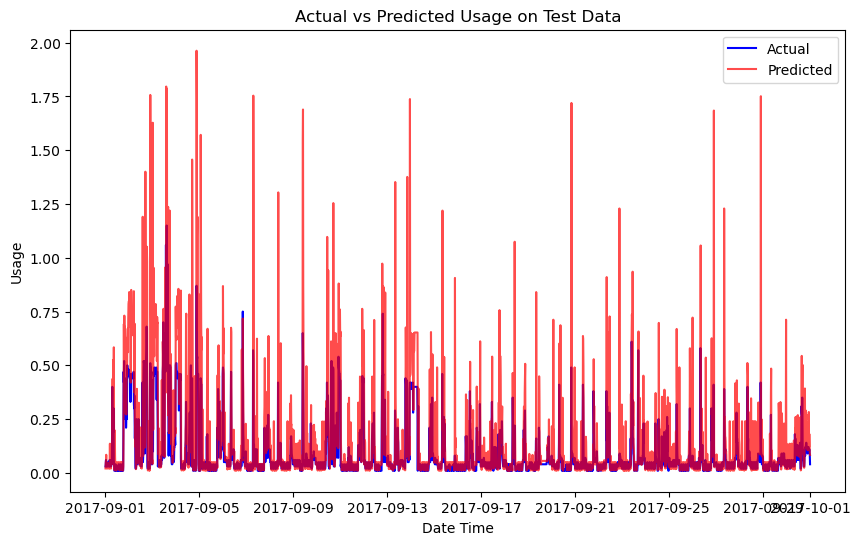

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(test_data['DATE_TIME'], test_data['USAGE'], label='Actual', color='blue')
plt.plot(test_data['DATE_TIME'], test_data['RF_PREDICTED'], label='Predicted', color='red', alpha=0.7)
plt.xlabel('Date Time')
plt.ylabel('Usage')
plt.title('Actual vs Predicted Usage on Test Data')
plt.legend()
plt.show()


### Prediction with Random Forest Model in Test Data

In [130]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

p = figure(title="Actual vs Predicted Usage", x_axis_type='datetime', width=800, height=350)

p.line(test_data['DATE_TIME'], test_data['USAGE'], color='blue', legend_label='Actual Usage', line_width=2)
p.line(test_data['DATE_TIME'], test_data['RF_PREDICTED'], color='red', legend_label='Predicted Usage', line_width=2)

p.legend.location = "top_left"
p.legend.click_policy = "hide"  # optional: allows toggling lines on/off

show(p)


Loading BokehJS ...

#### Prediction Single Day in Test Data

In [131]:
sep_30m = test_data[test_data.DATE_TIME >= pd.to_datetime("2017-09-30")]


In [132]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

p = figure(title="Usage Actual vs Predicted (from Sep 30, 2017)", 
           x_axis_type='datetime', width=900, height=350)

p.line(sep_30m['DATE_TIME'], sep_30m['USAGE'], color='blue', legend_label='Actual Usage', line_width=2)
p.line(sep_30m['DATE_TIME'], sep_30m['RF_PREDICTED'], color='red', legend_label='Predicted Usage', line_width=2)

p.legend.location = "top_left"
p.legend.click_policy = "hide"

show(p)


Loading BokehJS ...

### LSTM Modelling

In [133]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#### LSTM Model

In [134]:
model_k = Sequential()
model_k.add(LSTM(1, input_shape=(1,7)))
model_k.add(Dense(1))
model_k.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\kumar\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🔢 Line by line:
python
Copy
Edit
model_k = Sequential()
You're creating a sequential model — layers will be added one after the other in a stack.

python
Copy
Edit
model_k.add(LSTM(1, input_shape=(1,7)))
You're adding an LSTM layer with:

1 unit (very small — this is the size of the internal memory of the LSTM).

input_shape=(1, 7):

1 time step

7 features at each time step

This setup implies you're doing many-to-one prediction with a single timestep window and 7 input variables.

python
Copy
Edit
model_k.add(Dense(1))
Adds a fully connected output layer with a single neuron → outputs 1 value (e.g., your forecasted USAGE).

python
Copy
Edit
model_k.compile(loss='mean_squared_error', optimizer='adam')
You're compiling the model with:

Loss function: Mean Squared Error (MSE), typical for regression.

Optimizer: Adam, a widely used gradient-based optimizer.

💡 Summary:
You're building a very small LSTM to predict a single continuous value (e.g., electricity usage) from 7 input features in a 1-timestep window.

In [135]:
!pip install pydot


In [136]:
pip install graphviz


Note: you may need to restart the kernel to use updated packages.


In [138]:
pip install pydot pillow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_k, show_shapes=True, show_layer_names=True)


#### Reshape the data to 3D

In [139]:
X_t_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [140]:
X_val_resaped = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))

##### Fit the Model

In [141]:
history = model_k.fit(X_t_reshaped, y_train, validation_data=(X_val_resaped, y_val),\
epochs=10, batch_size=96, verbose=2)

Epoch 1/10
271/271 - 2s - 8ms/step - loss: 0.0740 - val_loss: 0.0154
Epoch 2/10
271/271 - 1s - 4ms/step - loss: 0.0498 - val_loss: 0.0200
Epoch 3/10
271/271 - 0s - 2ms/step - loss: 0.0414 - val_loss: 0.0250
Epoch 4/10
271/271 - 1s - 2ms/step - loss: 0.0378 - val_loss: 0.0287
Epoch 5/10
271/271 - 0s - 2ms/step - loss: 0.0356 - val_loss: 0.0315
Epoch 6/10
271/271 - 1s - 2ms/step - loss: 0.0340 - val_loss: 0.0333
Epoch 7/10
271/271 - 1s - 2ms/step - loss: 0.0328 - val_loss: 0.0368
Epoch 8/10
271/271 - 0s - 2ms/step - loss: 0.0318 - val_loss: 0.0376
Epoch 9/10
271/271 - 0s - 2ms/step - loss: 0.0310 - val_loss: 0.0361
Epoch 10/10
271/271 - 0s - 2ms/step - loss: 0.0305 - val_loss: 0.0395


You have a neural network model called model_k (looks like an LSTM model from before). You want to train it on some data.

X_t_reshaped and y_train are your training inputs and labels (features and targets).

validation_data=(X_val_resaped, y_val) means while training, after each epoch, the model will check how well it performs on validation data (data it hasn't trained on) to monitor progress and avoid overfitting.

epochs=10 means the model will go through the entire training dataset 10 times.

batch_size=96 means the model updates its learning after looking at 96 samples at a time.

verbose=2 controls the amount of output during training — here it will print a progress summary for each epoch.

In summary:

You’re telling your model:

“Train on this data for 10 full cycles, checking how well you do on the validation set after each cycle, updating your weights every 96 samples, and show me progress updates.”

Here's what  training output means, step-by-step:

Each line corresponds to one epoch (one full pass through the training data). You trained for 10 epochs total.

271/271 means there were 271 batches processed in that epoch (since your batch size splits your data into 271 parts).

The next time like 2s or 1s is how long that epoch took to run.

8ms/step means on average each batch took 8 milliseconds to process.

loss: this is the training loss (error) on your training data for that epoch. Lower is better.

val_loss: this is the loss on your validation data (data not used for training, just checking performance). Also, lower is better.

What the numbers tell you:
Your training loss keeps going down from 0.0740 to 0.0305. That means the model is learning to fit the training data better with each epoch.

Your validation loss starts low at 0.0154, but then it starts increasing a bit to around 0.0395 by the 10th epoch.

Interpretation:
Training loss is improving (good), but validation loss is getting worse after epoch 1 (starts increasing).

This suggests your model might be overfitting: it’s learning the training data too well but not generalizing to unseen validation data.

Overfitting means your model memorizes training data patterns that don't hold true on new data.

What can you do?
Try early stopping to stop training when validation loss starts to get worse.

Use regularization techniques or dropout layers.

Get more training data.

Tune hyperparameters like learning rate, batch size, or model size.

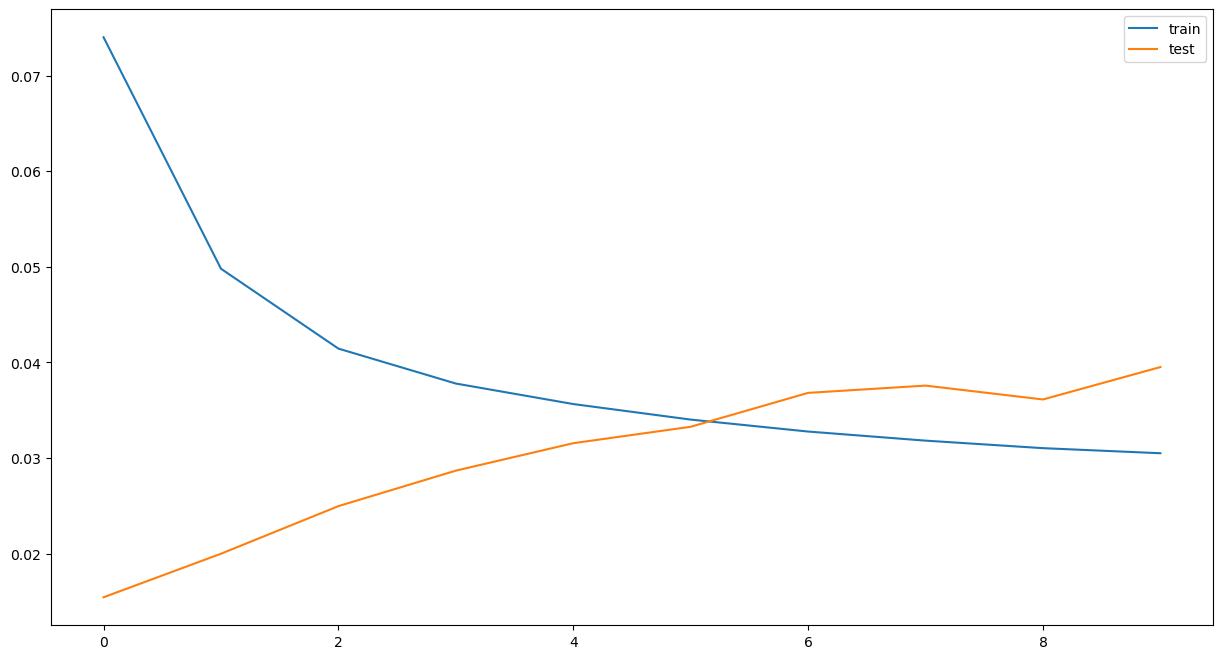

In [142]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [143]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [144]:
res = model_k.predict(X_te_reshaped)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [145]:
test_data["DL_PRED"] = res

C:\Users\kumar\AppData\Local\Temp\ipykernel_10024\1070672441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["DL_PRED"] = res


#### LSTM Prediction on Test Data

In [147]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Legend

output_notebook()

p = figure(title="Usage Actual vs Predicted", 
           x_axis_type='datetime', 
           width=900, height=350)

# Add lines for actual and predicted values
line1 = p.line(test_data["DATE_TIME"], test_data["USAGE"], 
               color="blue", legend_label="Actual Usage", line_width=2)
line2 = p.line(test_data["DATE_TIME"], test_data["RF_PREDICTED"], 
               color="red", legend_label="RF Predicted", line_width=2)

# Add DL prediction if available
if "DL_PRED" in test_data.columns:
    line3 = p.line(test_data["DATE_TIME"], test_data["DL_PRED"], 
                   color="green", legend_label="DL Predicted", line_width=2)

p.legend.location = "top_left"
p.legend.click_policy = "hide"

show(p)


Loading BokehJS ...

#### A Day on LSTM Predcted Result

In [149]:
sep_30m = test_data[test_data.DATE_TIME >= pd.to_datetime("09/30/2017")]

# Filter your data
#sep_30m = test_data[test_data.DATE_TIME >= pd.to_datetime("2017-09-30")]


from bokeh.plotting import figure, show, output_notebook

output_notebook()


p = figure(title="Usage Actual vs Predicted (from Sep 30, 2017)", 
           x_axis_type='datetime', width=900, height=350)

p.line(sep_30m['DATE_TIME'], sep_30m['USAGE'], color='blue', legend_label='Actual Usage', line_width=2)
p.line(sep_30m['DATE_TIME'], sep_30m['RF_PREDICTED'], color='red', legend_label='RF Predicted', line_width=2)

if "DL_PRED" in sep_30m.columns:
    p.line(sep_30m['DATE_TIME'], sep_30m['DL_PRED'], color='green', legend_label='DL Predicted', line_width=2)

p.legend.location = "top_left"
p.legend.click_policy = "hide"

show(p)


Loading BokehJS ...

#### RMSE Value of Random Forest and LSTM

In [150]:
from numpy import sqrt
sqrt(mean_squared_error(test_data.USAGE,test_data.DL_PRED))

0.16385493794123926

In [151]:
sqrt(mean_squared_error(test_data.USAGE,test_data.RF_PREDICTED))

0.1764555509472055

What is RMSE (Root Mean Squared Error)?
sqrt(mean_squared_error(actual, predicted)) gives you the RMSE.

RMSE measures the average magnitude of prediction errors — how far your predicted values are from the actual values, on average.

Lower RMSE means better predictions.

Your RMSE values:
Deep Learning model (DL_PRED): ~0.164

Random Forest (RF_PREDICTED): ~0.176

This means your DL model predictions are slightly closer to actual usage values than the Random Forest predictions on the test data.

How to interpret these numbers?
Both models have errors around 0.16 to 0.18 (depending on the scale of your usage data).

You should consider:

How big is your usage value typically? For example, if usage ranges around 1, then 0.16 RMSE is decent. But if usage ranges around 1000, 0.16 is very good.

Compare RMSE with your domain knowledge: Is this error acceptable for your application?

Is the model good?
Since DL model has a lower RMSE, it’s slightly better.

However, these RMSE values alone don’t tell the full story. You also want to:

Check plots of predicted vs actual values visually.

Evaluate metrics like R², MAE, etc.

Test if errors are consistent across time or specific periods.

What can be done next?
Tune hyperparameters of both models.

Try combining models (ensemble).

Use more features or data preprocessing.

Analyze error distribution to find where models fail.

Use early stopping and regularization for DL model to prevent overfitting.

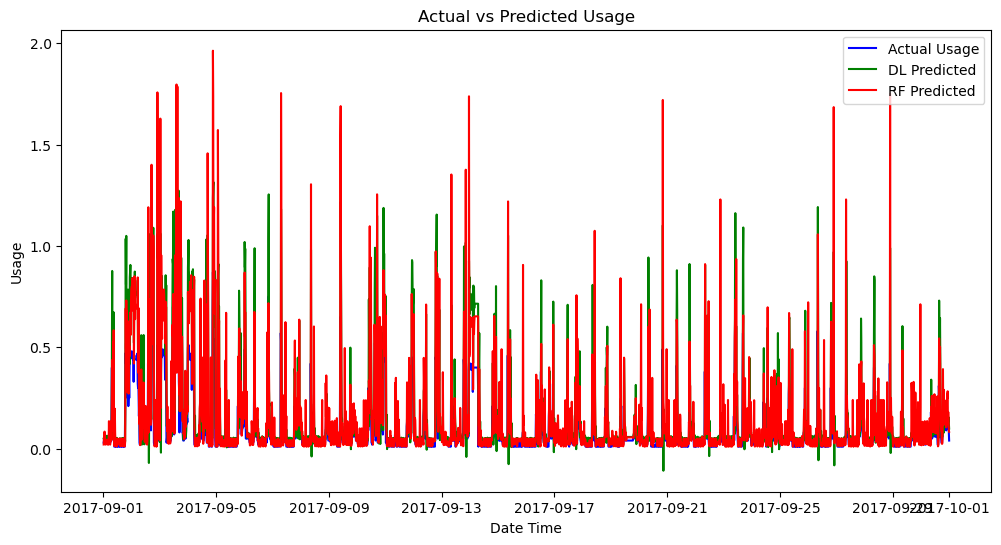

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_data['DATE_TIME'], test_data['USAGE'], label='Actual Usage', color='blue')
plt.plot(test_data['DATE_TIME'], test_data['DL_PRED'], label='DL Predicted', color='green')
plt.plot(test_data['DATE_TIME'], test_data['RF_PREDICTED'], label='RF Predicted', color='red')
plt.xlabel('Date Time')
plt.ylabel('Usage')
plt.title('Actual vs Predicted Usage')
plt.legend()
plt.show()


In [153]:
from sklearn.metrics import mean_absolute_error, r2_score

# For DL model
mae_dl = mean_absolute_error(test_data['USAGE'], test_data['DL_PRED'])
r2_dl = r2_score(test_data['USAGE'], test_data['DL_PRED'])

# For Random Forest
mae_rf = mean_absolute_error(test_data['USAGE'], test_data['RF_PREDICTED'])
r2_rf = r2_score(test_data['USAGE'], test_data['RF_PREDICTED'])

print(f"DL Model MAE: {mae_dl:.4f}")
print(f"DL Model R^2: {r2_dl:.4f}")
print(f"RF Model MAE: {mae_rf:.4f}")
print(f"RF Model R^2: {r2_rf:.4f}")


DL Model MAE: 0.0844
DL Model R^2: -0.5304
RF Model MAE: 0.0818
RF Model R^2: -0.7749


What you have:
Model	MAE	R²
DL Model	0.0844	-0.5304
RF Model	0.0818	-0.7749

What does this tell us?
MAE: Both models have pretty similar MAE (~0.08), so on average, predictions are off by about 0.08 units (whatever your usage unit is).

R² (Negative values!): This is important — negative R² means your model is worse than just predicting the average of the target every time. So neither model is really capturing the trend in the data well.

So, is the model good?
No, not really. Negative R² means the models are underperforming and struggling to explain any variance in the test data.

What can be done?
Feature engineering: Add more relevant features, lags, rolling averages, or external data.

Model tuning: Try different architectures, more layers, neurons, or tune hyperparameters.

More data: More quality data or longer time series can help.

Try other models: Gradient Boosting, XGBoost, or even simpler models like linear regression to establish baseline.

Cross-validation: Ensure your validation/test sets are representative.

Check data: Clean data, check for errors, anomalies, or outliers.